In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

In [20]:
# Libraries loading
import pandas as pd
import os
from datetime import datetime,timedelta
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #statistics for normality and skewness
import numpy as np

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


In [4]:
import copy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import missingno as msno
import statistics
from sklearn.impute import KNNImputer
import statistics
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc

from scipy.cluster.hierarchy import dendrogram, linkage

In [5]:
import pickle
import random
import numpy as np
import datetime
import time
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time

## Helpers

In [6]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [7]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp_initial = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta_initial = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp_initial.shape[0])
logging.info("%i matches WTA in df_wta", df_wta_initial.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Your work

In [8]:
df_atp_initial.head(2)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,6.0,4.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5,56,6.0,3.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print("nombre total des matchs : "+str(len(df_atp_initial)))


nombre total des matchs : 52298


In [10]:
print(list(df_atp_initial.columns))


['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets', 'Comment', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL', 'B365W', 'B365L', 'B&WW', 'B&WL', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL', 'AvgW', 'AvgL']


on supprime la colonne ATP, car elle n'est pas importante pour notre étude (surtout pour le classement)

In [11]:
df_atp_ID = df_atp_initial['ATP']
df_atp = df_atp_initial.copy()
#Drop de la colonne ATP 
df_atp.drop("ATP", axis = 1, inplace = True)

#verifions la taille des données
print("\nla taille des données aprés le drop de la colonne 'ATP' : {} ".format(df_atp.shape))


la taille des données aprés le drop de la colonne 'ATP' : (52298, 53) 


In [12]:
df_atp['Winner'].describe()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


count          52298
unique           948
top       Federer R.
freq            1121
Name: Winner, dtype: object

### Q1- Who are the three ATP players with the most wins ?


In [13]:
df_atp['Winner'].value_counts()[0:3]


Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

l'évolution du classement ATP des 3 grands joueurs; Federrer, Nadal et nivak:

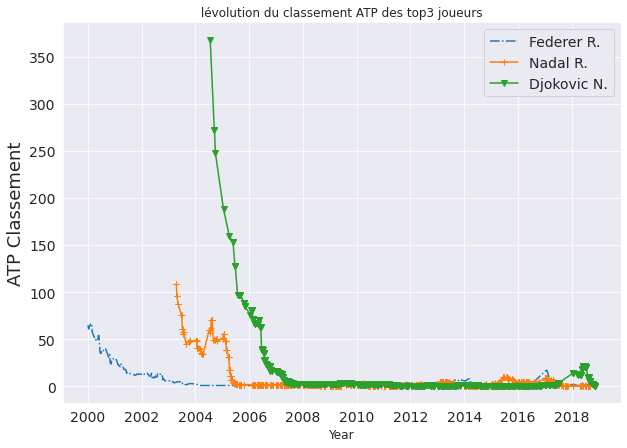

In [14]:
def rankings(df, player):
    """
    pour un joueur donné, cette fonction donne son classement et la date pour chaque match.
    """
    
    idx_w = df_atp[(df_atp.Winner == player)].index
    idx_l = df_atp[(df_atp.Loser == player)].index
    dates = df_atp.Date.iloc[idx_w.append(idx_l)].sort_index()
    rankings = df_atp['WRank'].iloc[idx_w].append(df_atp['LRank'].iloc[idx_l]).sort_index()
    return dates, rankings



fig = plt.figure(figsize=(10, 7))
x, y = rankings(df_atp, 'Federer R.')
plt.plot_date(x, y, '-.')
x, y = rankings(df_atp, 'Nadal R.')
plt.plot_date(x, y, '-+')
x, y = rankings(df_atp, 'Djokovic N.')
plt.plot_date(x, y, '-v')
plt.xlabel('Year', fontsize=12)
plt.ylabel('ATP Classement', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Federer R.', 'Nadal R.', 'Djokovic N.'], fontsize=14)
plt.title(' lévolution du classement ATP des top3 joueurs ')
plt.show()


In [15]:
print("'Federer R.'  a gagné " + str(len(df_atp[df_atp['Winner']=='Federer R.']) )+" et il a perdu " +str(len(df_atp[df_atp['Loser']=='Federer R.' ])))
print("'Nadal R.'    a gagné " + str(len(df_atp[df_atp['Winner']=='Nadal R.'])) +" et il a perdu " +str(len(df_atp[df_atp['Loser']=='Nadal R.' ])))
print("'Djokovic N.' a gagné " + str(len(df_atp[df_atp['Winner']=='Djokovic N.'])) +" et il a perdu " +str(len(df_atp[df_atp['Loser']=='Djokovic N.' ])))

'Federer R.'  a gagné 1121 et il a perdu 232
'Nadal R.'    a gagné 891 et il a perdu 189
'Djokovic N.' a gagné 802 et il a perdu 165


##### Le nombre des victoire aux grandSlams depuis l'année 2000: 

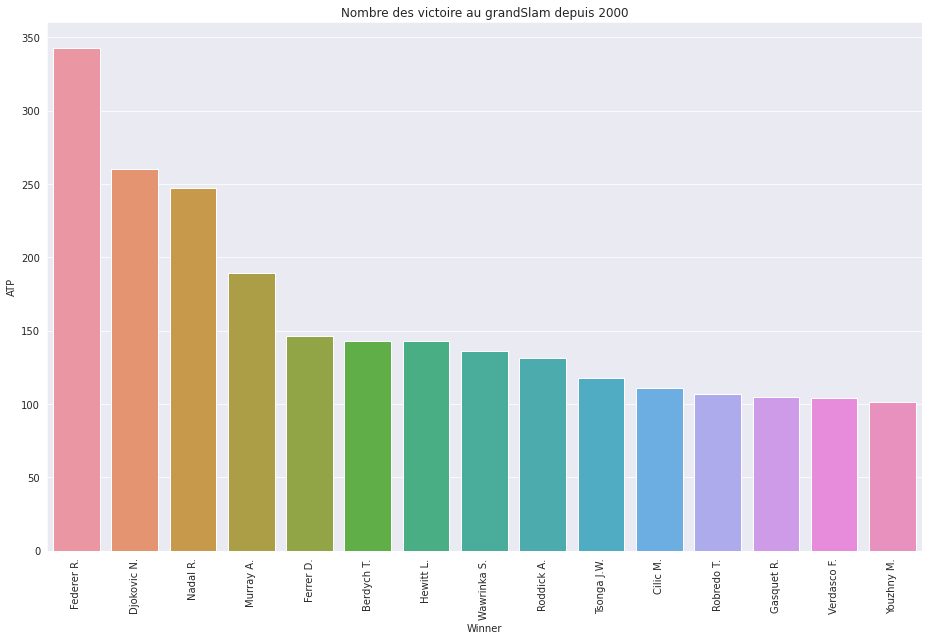

In [16]:
df_gs = df_atp_initial[df_atp.Series == 'Grand Slam'].groupby(['Winner']).agg({
    'ATP':'count'}).sort_values(by='ATP', ascending=False).iloc[0:15]
fig, ax = plt.subplots(figsize=(13,9))
ax = sn.barplot(x=df_gs.index, y=df_gs.ATP)
ax.set_xticklabels(labels=df_gs.index, rotation=90)
ax.set(title='Nombre des victoire au grandSlam depuis 2000')
ax.figure.tight_layout()
plt.show()

#### Le nombre et le type des granSlam gagnées pour chaque joueur

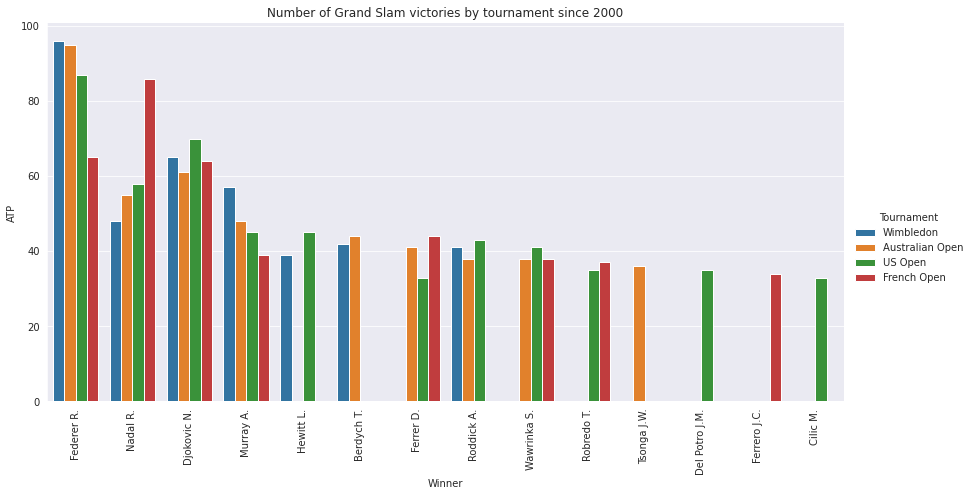

In [ ]:
df_gs2 = df_atp_initial[df_atp_initial.Series == 'Grand Slam'].groupby(['Winner', 'Tournament']).agg({
    'ATP':'count'}).sort_values(by='ATP', ascending=False).iloc[0:35]
df_gs2 = df_gs2.reset_index()
ax = sn.catplot(x='Winner', y='ATP', hue='Tournament', data=df_gs2, kind="bar",
                height=6, aspect=2)
ax.set_xticklabels(labels=df_gs2.Winner.unique(), rotation=90)
ax.set(title='Nombre des victoirs au granslam depuis 2000')
mpl.rcParams['figure.figsize'] = (13,9)
am_tournament.png")
plt.show()

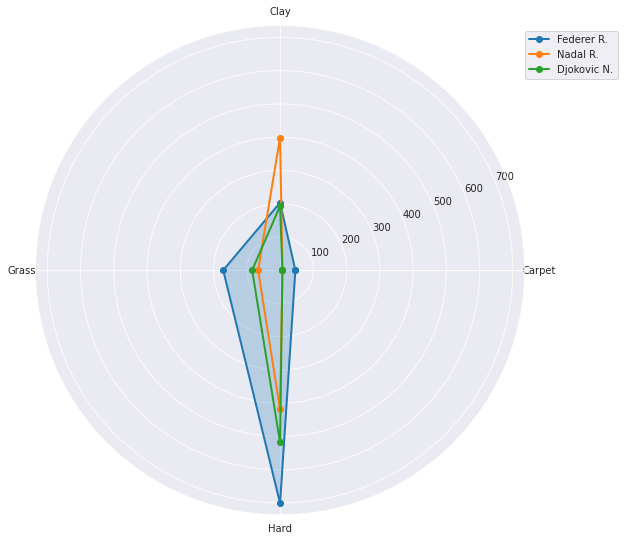

In [ ]:
df_sur = df_atp_initial.groupby(['Winner', 'Surface']).agg({'ATP':'count'})
df_FR = df_sur.loc['Federer R.']
df_NR = df_sur.loc['Nadal R.']
df_DN = df_sur.loc['Djokovic N.']
labels = df_FR.index
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))
FR = np.concatenate((df_FR.ATP,[df_FR.ATP[0]]))
NR = np.concatenate((df_NR.ATP,[df_NR.ATP[0]]))
DN = np.concatenate((df_DN.ATP,[df_DN.ATP[0]]))
fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, FR, 'o-', linewidth=2, label='Federer R.')
ax.plot(angles, NR, 'o-', linewidth=2, label='Nadal R.')
ax.plot(angles, DN, 'o-', linewidth=2, label='Djokovic N.')
ax.fill(angles, FR, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.2,1))
plt.show()

### C'est ce qu'on appelle la bataille des surfaces; Nadal est le roi de la terre battue (Roland-Garros), et federer est le roi de la surface gazon (wimbeldon).

### Q2- How many sets did the player “Federer R.” win in total ?



In [17]:
df_atp['Lsets']= pd.to_numeric(df_atp['Lsets'], errors='coerce')#tranforming str to numeric values and replcing with nan when we can't
N_sets = df_atp['Wsets'][df_atp['Winner']=='Federer R.'].sum() + df_atp['Lsets'][df_atp['Loser']=='Federer R.'].sum()

print('\n Le joueur “Federer R.” a gangé : ' + str(N_sets) + ' sets.\n')


 Le joueur “Federer R.” a gangé : 2695.0 sets.



### Q3- How many sets did the player “Federer R.” win during the years 2016 and 2017 ?

In [21]:
beg = datetime(2016,1,1)
end = datetime(2017,1,1)
df_atp_2016 = df_atp[(df_atp['Date']>=beg)&(df_atp['Date']<end)]

In [22]:
df_atp_2016['Wsets'][df_atp_2016['Winner']=='Federer R.'].sum() + df_atp_2016['Wsets'][df_atp_2016['Loser']=='Federer R.'].sum()


68.0

In [23]:
beg = datetime(2017,1,1)
end = datetime(2018,1,1)
df_atp_2017 = df_atp[(df_atp['Date']>=beg)&(df_atp['Date']<end)]

In [24]:
df_atp_2017['Wsets'][df_atp_2017['Winner']=='Federer R.'].sum() + df_atp_2017['Wsets'][df_atp_2017['Loser']=='Federer R.'].sum()


131.0

In [26]:
beg = datetime(2016,1,1)
end = datetime(2018,1,1)
df_atp_2017 = df_atp[(df_atp['Date']>=beg)&(df_atp['Date']<=end)]
print('Le nombre total des Sets que Federer a gagné est :', df_atp_2017['Wsets'][df_atp_2017['Winner']=='Federer R.'].sum() + df_atp_2017['Wsets'][df_atp_2017['Loser']=='Federer R.'].sum())

Le nombre total des Sets que Federer a gagné est : 199.0


### 4. For each match, what is the percentage of victories of the winner in the past ?



#### pour réponde à cette question on doit effectuer les étapes suivantes:

In [27]:
unique_player_index_and_score = {}
#Dictionary containing the player name as a key and the tuple (player_unique_index,x,y)
#x : number_of_matches_won
#y : number_of_matches played
# x and y are intiated 0 in the bigining but as we go through the data set we increment x and y by 1 if the player wins a match
# or we increment only y with 1 if the player loses a matches
i=0
for player in df_atp['Winner'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
for player in df_atp['Loser'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
        
print('nombre des joueurs uniques : ',i)

nombre des joueurs uniques :  1485


In [28]:
winner_loser_score_tracking_vector = np.zeros((len(df_atp),2)) 


In [29]:
df_atp=df_atp.sort_values(by='Date')


In [30]:
for c,row in enumerate(df_atp[['Winner','Loser']].values):
    score_winner = unique_player_index_and_score[row[0]]
    score_loser = unique_player_index_and_score[row[1]]
    if score_winner[2]<5:
        winner_loser_score_tracking_vector[c,0]=0.2
    else:
        winner_loser_score_tracking_vector[c,0] =score_winner[1]/score_winner[2]
    if score_loser[2]<5:
        winner_loser_score_tracking_vector[c,1]=0.2
    else:
        winner_loser_score_tracking_vector[c,1] = score_loser[1]/score_loser[2]
    #mise à jour du dictionnaire sur la base du nouveau résultat du match en cours
    unique_player_index_and_score[row[0]] = (score_winner[0],score_winner[1]+1,score_winner[2]+1)
    unique_player_index_and_score[row[1]] = (score_loser[0],score_loser[1],score_loser[2]+1)

In [31]:
df_atp['Winner_percentage'] = winner_loser_score_tracking_vector[:,0]
df_atp['Loser_percentage'] = winner_loser_score_tracking_vector[:,1]

In [32]:
df_atp['Winner_percentage'].describe()


count    52298.000000
mean         0.522795
std          0.142201
min          0.000000
25%          0.437500
50%          0.525933
75%          0.610799
max          1.000000
Name: Winner_percentage, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


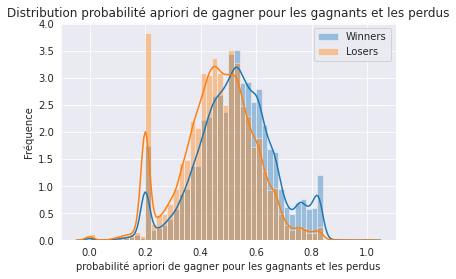

In [33]:
sns.distplot(df_atp['Winner_percentage'], label="Winners")
sns.distplot(df_atp['Loser_percentage'], label="Losers")
plt.ylabel('Fréquence')
plt.xlabel('probabilité apriori de gagner pour les gagnants et les perdus')
plt.title('Distribution probabilité apriori de gagner pour les gagnants et les perdus')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


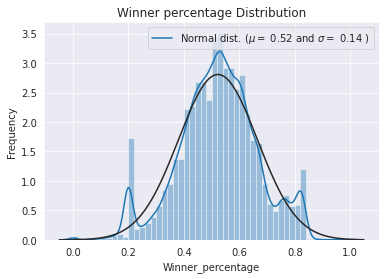

<Figure size 432x288 with 0 Axes>

In [34]:
sns.distplot(df_atp['Winner_percentage'] , fit=norm);

#Récupèrer les paramètres ajustés utilisés par la fonction
(mu, sigma) = norm.fit(df_atp['Winner_percentage'])
#Tracer la ditribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Winner percentage Distribution')
fig = plt.figure()


certains gagnants ont une probabilité de victoire préalable très élevée dans la plage [0.7 , 0.82]. Nous pouvons également voir que les gagnants ont tendance à gagner et les perdants à perdre à partir de l'intersection des deux histogrammes.

la distribution de la probabilité de victoire pour les gagnants a des valeurs extrêmes proches de 0,8 et la ditribution pour les perdants a de nombreuses valeurs proches de 0,2 (celles-ci concernent les joueurs qui n'ont pas encore joué 5 matchs dans un tournoi).
Les deux distributions suivent une ditribution presque normale. 

## EDA and Data analysis: 

#### Imputation des données manquantes:

Nous étudions par la suite les valeurs manquantes, leur nature, leur type et la relation entre les valeurs manquantes de chaque variable.

Nous verifions si Les données sont manquantes par omission prévisible et non ignorables (MOP) (les valeurs manquantes ne sont pas aléatoires) donc la valeur de la variable manquante est liée à la raison pour laquelle elle est manquante ou le cas contraire c'est à dire les valeur manquantes sont alèatoires(complètement ou partiellement) 

In [36]:
print([c for c in df_atp.columns if df_atp[str(c)].dtypes == 'object'])

['Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round', 'Winner', 'Loser', 'WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Comment', 'EXW']


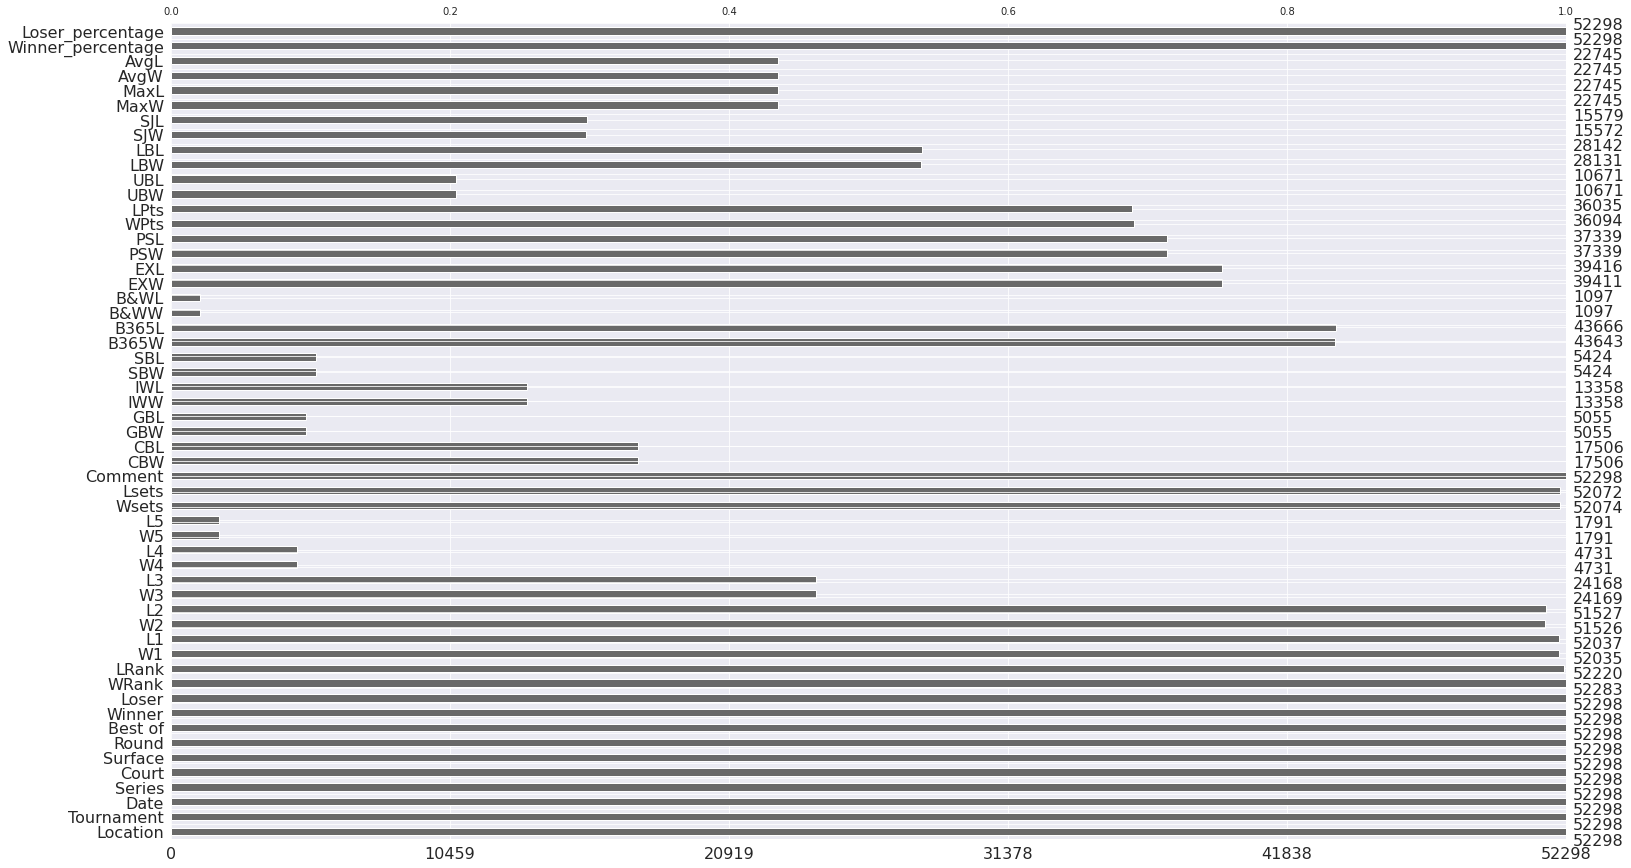

In [37]:
msno.bar(df_atp) # on affiche le pourcentage des valeur manquantes par variable

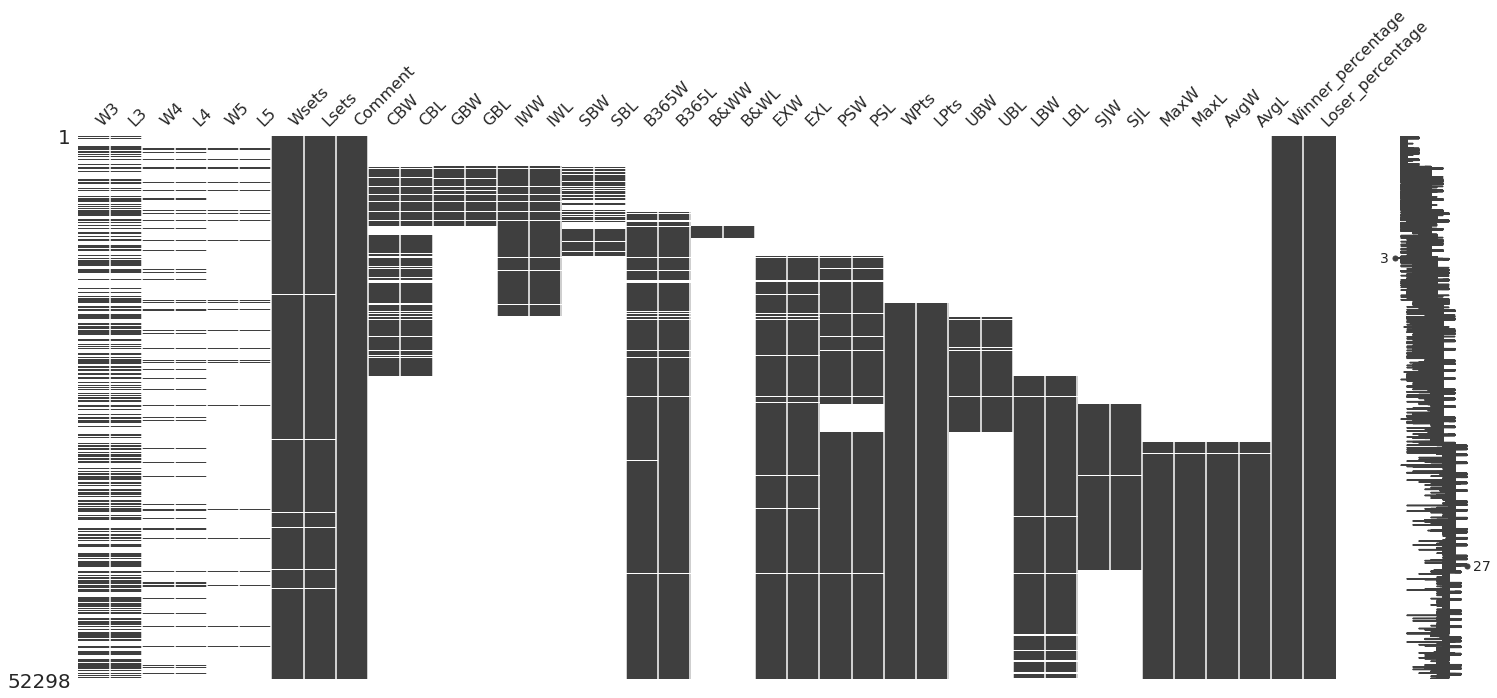

In [ ]:
msno.matrix(df_atp.iloc[:, 16:]) # on visualise la relation entre les données manquantes des différentes variables pour 
# voir s'ils sont manquantes aléatoirement ou non 

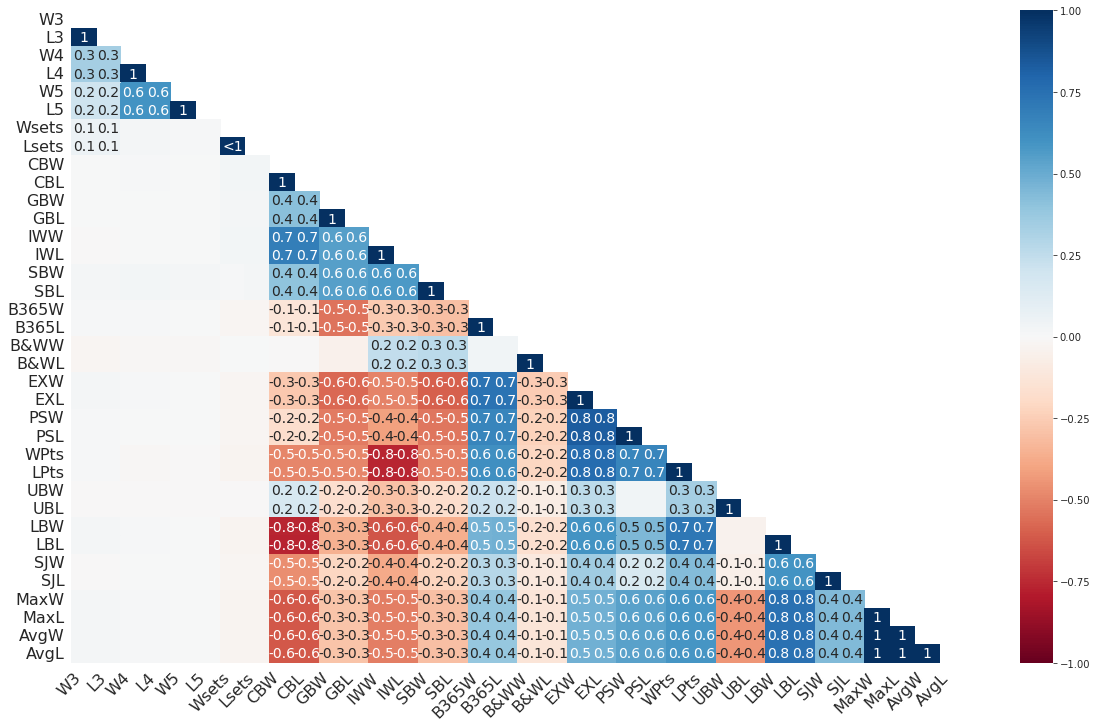

In [ ]:
msno.heatmap(df_atp.iloc[:,16:]) # on affiche la matrice de corrélation entre les valeurs manquantes pour vérifier la dépendance entre les valeurs manquantes
# des variables

la procédure:  

*   Les colonnes L5,L4,W4,W5 ont des valeurs manquantes car certains matchs ont seulement la règle du "le meilleur sur les 3 sets" alors que d'autres ont la règle du " le meilleur sur les 5 sets".
*   Nous ne pouvons pas utiliser les colonnes L1 à L5 ou W5 à W1 dans les données d'entraînement de notre phase de modélisation car ces variables sont définies après la fin des matchs. Nous allons donc supprimer ces colonnes également.
*   Les variables MaxW, MaxL, AvgW, AvgL ont plus de 60% des valeurs manquantes donc sont à supprimé.
*  Pour les variables Lsets, Wsets, Wpts, Lpts; on remplace les NANs par le mode ou la moyenne car on va les utiliser pour créer de nouvelles variables.






In [38]:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Pourcentage of missing values' :train_na})


In [39]:
#Drop the columns with missing values and that we won't be using:
for column in train_na.index[:26]:
    df_atp.drop(column, axis = 1, inplace = True)

Text(0.5, 1.0, 'Pourcentage of missing values by variables')

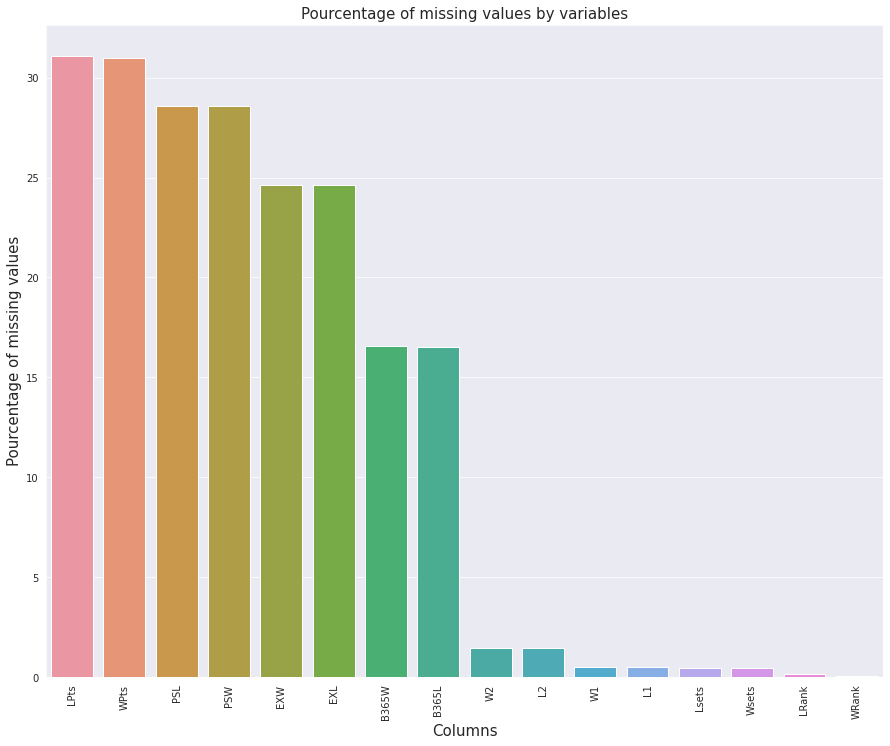

In [40]:
#With a visiualisation:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Pourcentage of missing values' :train_na})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Columns', fontsize=15)
plt.ylabel('Pourcentage of missing values', fontsize=15)
plt.title('Pourcentage of missing values by variables', fontsize=15)

In [41]:
df_atp.drop('W1', axis = 1, inplace = True)
df_atp.drop('L1', axis = 1, inplace = True)
df_atp.drop('W2', axis = 1, inplace = True)
df_atp.drop('L2', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


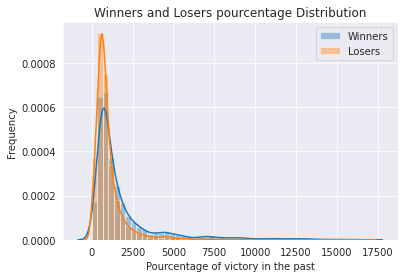

In [42]:
sns.distplot(df_atp['WPts'].dropna(), label="Winners")
sns.distplot(df_atp['LPts'].dropna(), label="Losers")
plt.ylabel('Frequency')
plt.xlabel('Pourcentage of victory in the past')
plt.title('Winners and Losers pourcentage Distribution')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


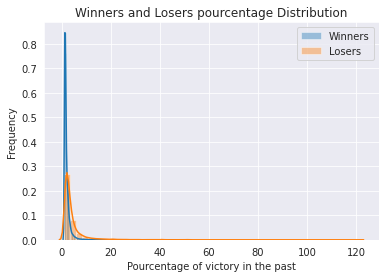

In [43]:
sns.distplot(df_atp['PSW'].dropna(), label="Winners")
sns.distplot(df_atp['PSL'].dropna(), label="Losers")
plt.ylabel('Frequency')
plt.xlabel('Pourcentage of victory in the past')
plt.title('Winners and Losers pourcentage Distribution')
plt.legend()

In [44]:
df_atp['EXW']= pd.to_numeric(df_atp['EXW'], errors='coerce')

In [45]:
df_atp['B365W']= pd.to_numeric(df_atp['B365W'], errors='coerce')

In [46]:
df_atp['Wsets']=pd.to_numeric(df_atp['Wsets'],errors='coerce' )

In [47]:
df_atp['LRank']=pd.to_numeric(df_atp['LRank'],errors='coerce' )
df_atp['WRank']=pd.to_numeric(df_atp['WRank'],errors='coerce' )

In [48]:
columns=['WPts','LPts','PSW','PSL','EXW','EXL','B365W','B365L','Lsets','Wsets','LRank','WRank']
for column in columns:
    df_atp[column]=df_atp[column].fillna(float(df_atp[column].mode()[0]))

In [49]:
df_atp.head(2)

,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,B365W,B365L,EXW,EXL,PSW,PSL,WPts,LPts,Winner_percentage,Loser_percentage
0,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63.0,77.0,2.0,0.0,Completed,1.4,2.75,1.35,2.35,1.38,2.2,1295.0,825.0,0.2,0.2
68,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,Tarango J.,6.0,59.0,2.0,0.0,Completed,1.4,2.75,1.35,2.35,1.38,2.2,1295.0,825.0,0.2,0.2


In [50]:
#df_atp["Labels"] = df_atp.apply(lambda row: 1 if row["Winner"] < row["Loser"] else 0, axis=1)
#display(df_atp[["Winner", "Loser", "Labels"]].head(5))

#print('The number of 1 : {}'.format(df_atp[df_atp["Labels"] == 1].shape[0]))
#print('The number of 0s : {}'.format(df_atp[df_atp["Labels"] == 0].shape[0]))
#print('We notice that there is no Imbalanced Data issue !')


Nous vérifions encore une fois le pourcentage des valeurs manquantes dans chaque variables

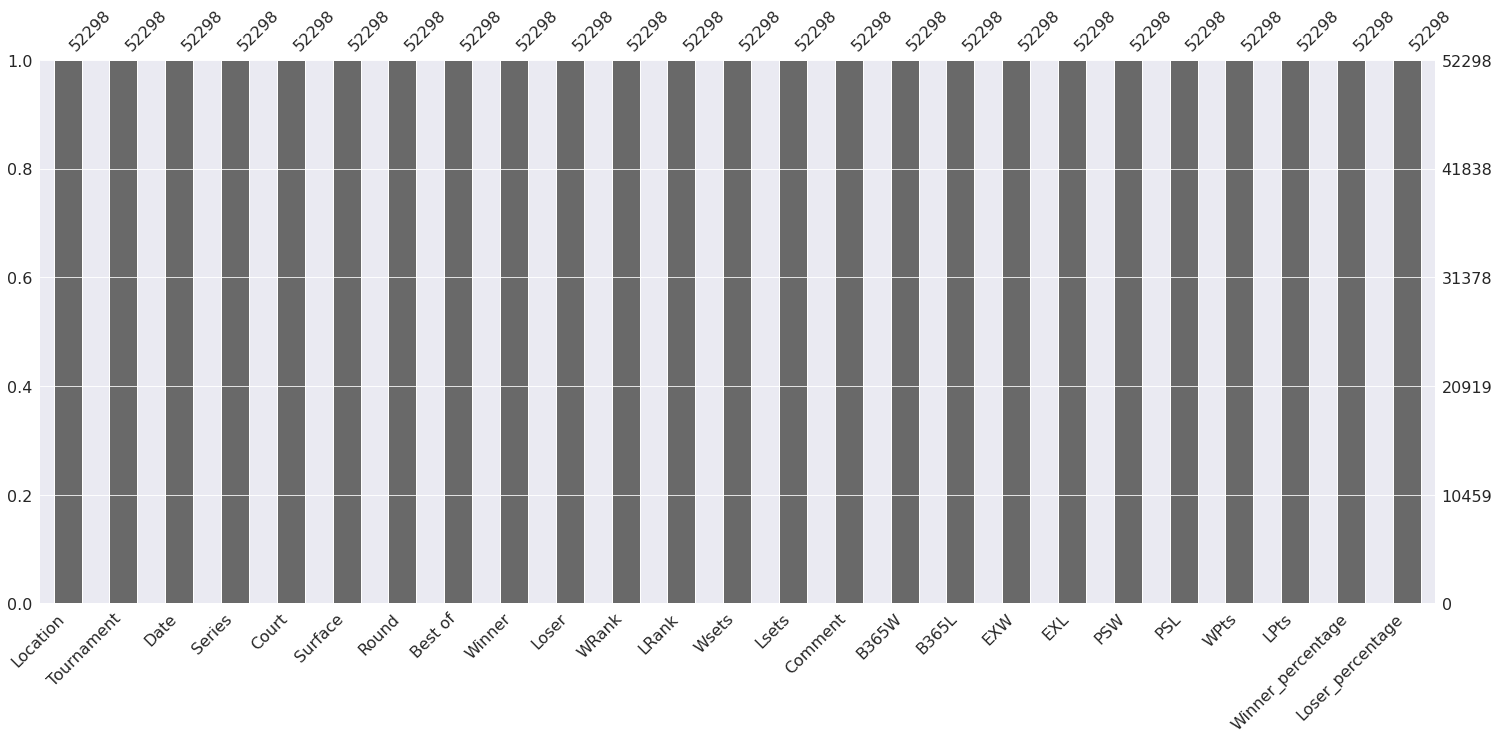

In [51]:
msno.bar(df_atp)



*   Nous allons pas utiliser la variable Comment car elle trouvé aprés la fin du match, c'est le mème cas pour Wsets et Lsets (aprés la créationd es nouvelles variables)


In [52]:
df_atp.drop("Comment", axis = 1, inplace = True)

Nous claculons maintenant l'indice de classement ELO: 
Le système d'évaluation Elo est une méthode permettant de calculer le niveau de compétence relatif des joueurs dans les jeux à somme nulle tels que les échecs. Il porte le nom de son créateur, Arpad Elo, un professeur de physique américain.

La différence de classement entre deux joueurs permet de prédire le résultat d'un match. Deux joueurs ayant le mème niveau et classement qui s'affrontent sont censés remporter le même nombre de victoires. Un joueur dont le "rating" est supérieure de 100 points à celle de son adversaire devrait obtenir un score de 64 % ; si la différence est de 200 points, le score attendu du joueur le plus fort est de 76 %.


In [53]:
def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings ...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin)
        new_elol=elol-K_los*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matchs calculés...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo

In [54]:
#Nous appliquons le score ELO:
Elo =  compute_elo_rankings(df_atp)


Elo rankings ...
5000 matchs calculés...
10000 matchs calculés...
15000 matchs calculés...
20000 matchs calculés...
25000 matchs calculés...
30000 matchs calculés...
35000 matchs calculés...
40000 matchs calculés...
45000 matchs calculés...
50000 matchs calculés...


Pour chaque ligne décrivant un match, nous aurons deux lignes résultantes. L'une avec la variable cible 1 et nous gardons les colonnes telles qu'elles sont et l'autre avec la variable cible 0 nous inversons la colonne du gagnant avec celle du perdant et la colonne du perdant avec celle du gagnant et nous gardons le reste des colonnes telles qu'elles sont. Cela doublera la quantité de nos données de transfert et transformera également notre problème en un problème de classification binaire.

In [55]:
features_categorical = df_atp[["Series","Court","Surface","Round","Best of","Tournament"]].copy()
features_onehot = pd.get_dummies(features_categorical)

In [56]:
df_atp["Elo_Winner"] = Elo["elo_winner"]
df_atp["Elo_Loser"] = Elo["elo_loser"]
df_atp["Proba_Elo"]= Elo["proba_elo"]


In [57]:
target_1 = np.ones(len(df_atp))
target_2 = np.zeros(len(df_atp))
target_1 = pd.DataFrame(target_1,columns=['label'])
target_2 = pd.DataFrame(target_2,columns=['label'])

In [58]:
# Elo data
elo_rankings = df_atp[["Elo_Winner","Elo_Loser","Proba_Elo"]]
elo_1 = elo_rankings
elo_2 = elo_1[["Elo_Loser","Elo_Winner","Proba_Elo"]]
elo_2.columns = ["Elo_Winner","Elo_Loser","Proba_Elo"]
elo_2.Proba_Elo = 1-elo_2.Proba_Elo

In [59]:
win_pourcentage = df_atp[['Winner_percentage', 'Loser_percentage']]
win_1 = win_pourcentage
win_2 = win_1[['Loser_percentage','Winner_percentage']]
win_2.columns = ['Winner_percentage', 'Loser_percentage']

In [60]:
print(df_atp.columns)

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets',
       'B365W', 'B365L', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts',
       'Winner_percentage', 'Loser_percentage', 'Elo_Winner', 'Elo_Loser',
       'Proba_Elo'],
      dtype='object')


In [61]:
unique_player_index_and_score = {}
#x : number_of_set_won
#y : number_of_sets_played
# x and y are intiated 0 in the bigining but as we go through the data set we increment x Wsets(or Lsets) witch are the number of
# won by matches winner(orloser) and we increment y by Wsets+Lsets wich is the number of stes played in that match
i=0
for player in df_atp['Winner'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
for player in df_atp['Loser'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
        
print('Number of unqiue player names : ',i)
winner_loser_score_tracking_vector = np.zeros((len(df_atp),2)) 
# two columns one to track the winner percetage and the other for the loser percentage 
df_atp=df_atp.sort_values(by='Date')
for i in range(len(df_atp)):
    row=[df_atp.Winner[i],df_atp.Loser[i]]
    score_winner = unique_player_index_and_score[row[0]]
    score_loser = unique_player_index_and_score[row[1]]
    if int(score_winner[2])<15:
        winner_loser_score_tracking_vector[i,0]=0.2
    else:
        winner_loser_score_tracking_vector[i,0] =score_winner[1]/score_winner[2]
    if score_loser[2]<15:
        winner_loser_score_tracking_vector[i,1]=0.2
    else:
        winner_loser_score_tracking_vector[i,1] = score_loser[1]/score_loser[2]
    #updating the dictionary based on the new outcome of the current match
    unique_player_index_and_score[row[0]] = (score_winner[0],score_winner[1]+float(df_atp.Wsets[i]),score_winner[2]+float(df_atp.Wsets[i]+df_atp.Lsets[i]))#Winner
    unique_player_index_and_score[row[1]] = (score_loser[0],score_loser[1]+float(df_atp.Lsets[i]),score_loser[2]+float(df_atp.Wsets[i]+df_atp.Lsets[i]))#loser
    
df_atp['Winner_set_percentage'] = winner_loser_score_tracking_vector[:,0]
df_atp['Loser_set_percentage'] = winner_loser_score_tracking_vector[:,1]

Number of unqiue player names :  1485


In [62]:
# Player prior win set probability
set_win_pourcentage = df_atp[['Winner_set_percentage','Loser_set_percentage']]
set_1 = set_win_pourcentage
set_2 = set_1[['Loser_set_percentage','Winner_set_percentage']]
set_2.columns = ['Winner_set_percentage','Loser_set_percentage']

In [63]:
# Player entry points
Pts = df_atp[['WPts','LPts']]
Pts_1 = Pts
Pts_2 = Pts_1[['LPts','WPts']]
Pts_2.columns = ['WPts','LPts']

In [64]:
# Player Entry Ranking
Rank = df_atp[['WRank','LRank']]
Rank_1 = Rank
Rank_2 = Rank_1[['LRank','WRank']]
Rank_2.columns = ['LRank','WRank']


In [65]:
#Player Odds for winning
Odds = df_atp[['EXW','EXL','PSW','PSL','B365W','B365L']]
Odds_1 = Odds
Odds_2 = Odds_1[['EXL','EXW','PSL','PSW','B365L','B365W']]
Odds_2.columns = ['EXW','EXL','PSW','PSL','B365W','B365L']

In [66]:
#Date 
Date_1 = df_atp.Date
Date_2 = df_atp.Date
elo_2.index = range(1,2*len(elo_1),2)
elo_1.index = range(0,2*len(elo_1),2)
win_1.index = range(0,2*len(win_1),2)
win_2.index = range(0,2*len(win_1),2)
set_1.index = range(0,2*len(set_1),2)
set_2.index = range(0,2*len(set_1),2)
Pts_1.index = range(0,2*len(Pts_1),2)
Pts_2.index = range(0,2*len(Pts_1),2)
Rank_1.index = range(0,2*len(Rank_1),2)
Rank_2.index = range(0,2*len(Rank_1),2)
Odds_1.index = range(0,2*len(Odds_1),2)
Odds_2.index = range(0,2*len(Odds_1),2)
Date_1.index = range(0,2*len(Date_1),2)
Date_2.index = range(0,2*len(Date_1),2)
target_1.index = range(0,2*len(target_1),2)
target_2.index = range(0,2*len(target_1),2)
features_elo_ranking = pd.concat([elo_1,elo_2]).sort_index(kind='merge')
features_win_pourcentage = pd.concat([win_1,win_2]).sort_index(kind='merge')
features_set_pourcentage = pd.concat([set_1,set_2]).sort_index(kind='merge')
features_Pts = pd.concat([Pts_1,Pts_2]).sort_index(kind='merge')
features_Rank =  pd.concat([Rank_1,Rank_2]).sort_index(kind='merge')
features_Odds = pd.concat([Odds_1,Odds_2]).sort_index(kind='merge')
target = pd.concat([target_1,target_2]).sort_index(kind='merge')
Date = pd.concat([Date_1,Date_2]).sort_index(kind='merge').to_frame()

In [67]:
features_onehot = pd.DataFrame(np.repeat(features_onehot.values,2, axis=0),columns=features_onehot.columns)
features_onehot.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Odds.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_elo_ranking.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_win_pourcentage.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_set_pourcentage.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Pts.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Rank.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Odds.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
target.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
Date.set_index(pd.Series(range(0,2*len(df_atp))),inplace=True)

In [68]:
print(df_atp.columns)

Index(['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round',
       'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets',
       'B365W', 'B365L', 'EXW', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts',
       'Winner_percentage', 'Loser_percentage', 'Elo_Winner', 'Elo_Loser',
       'Proba_Elo', 'Winner_set_percentage', 'Loser_set_percentage'],
      dtype='object')


La matrice des données finale pour l'entraienemnt du modèle

In [69]:
### La matrice d'entrée pour l'entrainement 
features = pd.concat([features_win_pourcentage,
                  features_set_pourcentage,
                  features_elo_ranking,
                  features_Pts,
                  features_Rank,
                  features_Odds,
                  features_onehot,
                  Date,
                  target],1)


Nous prenons les données de l'année 2018 pour le test de notre modèle

In [70]:
end_train = datetime(2018,1,1)
beg_test = datetime(2018,1,1)
end_test = datetime(2019,1,1)
train = features[features['Date']<end_train]
test = features[(features['Date']>=beg_test)&(features['Date']<end_test)]

On peut supprimer d'autres variables qui ne sont pas utilise pour notre apprentissage

In [72]:
X_train = train.drop(columns=['Date','label','EXW', 'EXL', 'PSW', 'PSL', 'B365W', 'B365L'])
y_train = train['label']

In [80]:
X_test = test.drop(columns=['Date','label','EXW', 'EXL', 'PSW', 'PSL', 'B365W', 'B365L'], axis=1)
y_test = test["label"]

# Modélisation:

Nous fixons tout d'abord notre métrique d'évaluation des différent modèles qu'on va réaliser.

In [83]:
def classification_report(y_true, y_pred, name_classifiers, train_time=None):
    assert(len(y_pred) == len(name_classifiers))
    assert(len(train_time) == len(name_classifiers) if train_time else True)
    
    reports = []
    metrics = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
    if train_time:
        metrics = metrics + ["Training Duration (seconds)"]

    for idx, y_clf in enumerate(y_pred):
        acc = accuracy_score(y_true, y_clf)
        pre = precision_score(y_true, y_clf)
        rec = recall_score(y_true, y_clf)
        f1s = f1_score(y_true, y_clf)
        report = (name_classifiers[idx], acc, pre, rec, f1s)
        if train_time:
            report = report + (train_time[idx], )
        reports.append(report)
            
    display(pd.DataFrame.from_records(reports, columns=metrics))

Aprés nous allons définir et initialiser les modèles qu'on va utiliser.

In [84]:
names = ["Nearest Neighbors",
         "Decision Tree", "MLP"] 
classifiers = [ 
    KNeighborsClassifier(5, n_jobs=-1),
    DecisionTreeClassifier(max_depth=10),
    MLPClassifier(alpha=0.0001)]
y_pred = []
train_time = []

for name, clf in zip(names, classifiers):
    tic = time()
    clf.fit(X_train, y_train)
    toc = time()
    
    y_pred.append(clf.predict(X_train))
    train_time.append(toc - tic)
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))

Classifier : Nearest Neighbors ===> Training duration : 0.25809574127197266 sec
Classifier : Decision Tree ===> Training duration : 2.6933703422546387 sec
Classifier : MLP ===> Training duration : 181.96917295455933 sec


In [85]:
classification_report(y_train, y_pred, names, train_time)

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Duration (seconds)
0,Nearest Neighbors,0.937559,0.937559,0.937559,0.937559,0.258096
1,Decision Tree,0.906097,0.905208,0.907194,0.906200,2.693370
2,MLP,0.961863,0.934974,0.992771,0.963006,181.969173


In [86]:
y_test_pred = []

for name, clf in zip(names, classifiers):
    y_test_pred.append(clf.predict(X_test))

In [87]:
classification_report(y_test, y_test_pred, names)

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Nearest Neighbors,0.828843,0.828843,0.828843,0.828843
1,Decision Tree,0.812334,0.808009,0.819355,0.813642
2,MLP,0.946869,0.909565,0.992410,0.949183


### Améliorations:    
Réglage des hyper-paramètres pour ces modèles.

Utilisation d'une approche de modélisation générative (chaîne de Markov).

Essayer des modèles plus discriminants : SVM, XGBOOST.

Plus d'ingénierie des caractéristiques (hand-crafted features).

Faire un EDA plus "extensive".

Changer le codage des variables catégorielles.

Utiliser NN avec keras ou TensorFlow.
